In [1]:
%env CUDA_VISIBLE_DEVICES=6

import torch
import math

from bitsandbytes.functional import (
    quantize_fp4, quantize_nf4, quantize_blockwise,
    dequantize_fp4, dequantize_nf4, dequantize_blockwise,
)

from gptq.edenn import higgs_quantize_dequantize

from tqdm.auto import trange, tqdm

env: CUDA_VISIBLE_DEVICES=6


In [2]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3.1-8B", torch_dtype="auto", device_map="cpu")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
weight = model.model.layers[0].self_attn.q_proj.weight.data.cuda().clone().detach()

(0.0, 1.049983226868605)

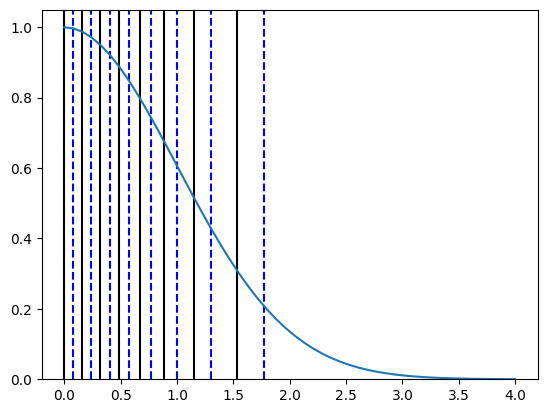

In [4]:
from scipy.stats import norm

nf4_boundaries = norm.ppf(torch.linspace(0.5, 1 - 1/16, 8)).tolist()

nf4_centers = [nf4_boundaries[1] / 2]
for i in range(len(nf4_boundaries) - 1):
    nf4_centers.append(2 * nf4_boundaries[i + 1] - nf4_centers[i])

import matplotlib.pyplot as plt
import numpy as np

for b in nf4_boundaries:
    plt.axvline(b, color="black")
    
for c in nf4_centers:
    plt.axvline(c, color="blue", linestyle="--")
    
plt.plot(np.linspace(0, 4), np.exp(-np.linspace(0, 4)**2/2))

plt.ylim(0, None)

In [5]:
NF4_GRID = torch.asarray(nf4_centers)[:, None].float().cuda()
NF4_GRID = torch.cat((-torch.flip(NF4_GRID, dims=(0,)), NF4_GRID), dim=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.0, 1.0464905066018135)

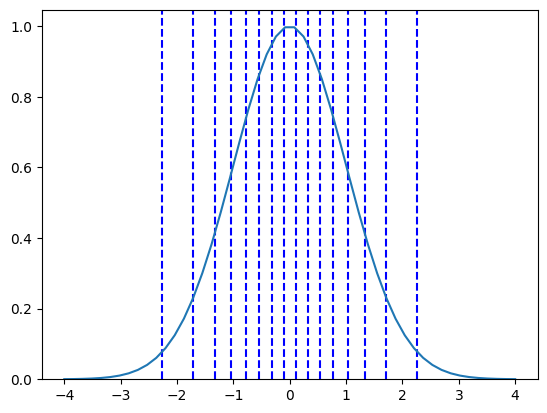

In [6]:
af_4_centers = np.linspace(-1, 1, num=16, endpoint=True)


for i in trange(1000):
    af_4_boundaries_quantiles = [0.0] + [norm.cdf((af_4_centers[i] + af_4_centers[i + 1]) / 2) for i in range(len(af_4_centers) - 1)] + [1.0]
    af_4_centers = [norm.ppf((af_4_boundaries_quantiles[i] + af_4_boundaries_quantiles[i + 1]) / 2) for i in range(len(af_4_boundaries_quantiles) - 1)]
    
    
import matplotlib.pyplot as plt
import numpy as np

for c in af_4_centers:
    plt.axvline(c, color="blue", linestyle="--")
    
plt.plot(np.linspace(-4, 4), np.exp(-np.linspace(-4, 4)**2/2))

plt.ylim(0, None)

In [7]:
AF4_GRID = torch.asarray(af_4_centers)[:, None].float().cuda()

In [8]:
@torch.no_grad()
def higgs_grouped_quantize_dequantize(weight, d, n, group_size=1024):
    weight = weight.clone().detach().reshape(weight.shape[0], -1, group_size).float()
    scales = torch.norm(weight, dim=-1)[..., None] / math.sqrt(group_size)
    weight = weight / scales
    
    orig_shape = weight.shape
    
    weight, _ = higgs_quantize_dequantize(weight.reshape(-1, d), d, n)
    
    weight = weight.reshape(orig_shape)

    return (weight * scales).reshape(weight.shape[0], -1)


def create_nf4_grid(offset=0.9677083, symmetric=True):
    from scipy.stats import norm
    
    if symmetric:
        v = norm.ppf(torch.linspace(1/17, 1, 16)[:-1]).tolist()
    else:
        # one more positive value, this is an asymmetric type
        v1 = norm.ppf(torch.linspace(offset, 0.5, 9)[:-1]).tolist()
        v3 = (-norm.ppf(torch.linspace(offset, 0.5, 8)[:-1])).tolist()
        v = v1 + v3

    values = torch.Tensor(v)
    values = values.sort().values

    return values[:,None]

ASYMMETRIC_NF4_GRID = create_nf4_grid(symmetric=False).cuda()

@torch.no_grad()
def custom_grouped_quantize_dequantize(weight, grid, group_size=1024):
    weight = weight.clone().detach().reshape(weight.shape[0], -1, group_size).float()
    scales = torch.norm(weight, dim=-1)[..., None] / math.sqrt(group_size)
    weight = weight / scales
    
    orig_shape = weight.shape
    
    ids = torch.argmax(2 * weight[..., None] @ grid.T - torch.linalg.norm(grid, dim=1) ** 2, -1)
    weight = grid[ids]
    
    weight = weight.reshape(orig_shape)

    return (weight * scales).reshape(weight.shape[0], -1)

In [9]:
nf4_weight = custom_grouped_quantize_dequantize(weight, NF4_GRID)
asymnf4_weight = custom_grouped_quantize_dequantize(weight, ASYMMETRIC_NF4_GRID)
af4_weight = custom_grouped_quantize_dequantize(weight, AF4_GRID)
higgs_1_weight = higgs_grouped_quantize_dequantize(weight, 1, 2**4)
higgs_2_weight = higgs_grouped_quantize_dequantize(weight, 2, 2**8)

In [10]:
print("No Hadamard:")
print(f"nf4 relative mse: {torch.norm(nf4_weight - weight)**2 / torch.norm(weight)**2:.4f}")
print(f"orig nf4 relative mse: {torch.norm(asymnf4_weight - weight)**2 / torch.norm(weight)**2:.4f}")
print(f"af4 relative mse: {torch.norm(af4_weight - weight)**2 / torch.norm(weight)**2:.4f}")
print(f"EDEN relative mse: {torch.norm(higgs_1_weight - weight)**2 / torch.norm(weight)**2:.4f}")
print(f"HIGGS (2D) relative mse: {torch.norm(higgs_2_weight - weight)**2 / torch.norm(weight)**2:.4f}")

No Hadamard:
nf4 relative mse: 0.1299
orig nf4 relative mse: 0.1242
af4 relative mse: 0.0779
EDEN relative mse: 0.0502
HIGGS (2D) relative mse: 0.0354


In [11]:
import math

from fast_hadamard_transform import hadamard_transform

h_weight = hadamard_transform(weight, scale=1/math.sqrt(weight.shape[-1]))

nf4_h_weight = custom_grouped_quantize_dequantize(h_weight, NF4_GRID)
asymnf4_h_weight = custom_grouped_quantize_dequantize(h_weight, ASYMMETRIC_NF4_GRID)
af4_h_weight = custom_grouped_quantize_dequantize(h_weight, AF4_GRID)
higgs_1_h_weight = higgs_grouped_quantize_dequantize(h_weight, 1, 2**4)
higgs_2_h_weight = higgs_grouped_quantize_dequantize(h_weight, 2, 2**8)

In [12]:
print("Hadamard:")
print(f"nf4 relative mse: {torch.norm(nf4_h_weight - h_weight)**2 / torch.norm(h_weight)**2:.4f}")
print(f"orig nf4 relative mse: {torch.norm(asymnf4_h_weight - h_weight)**2 / torch.norm(h_weight)**2:.4f}")
print(f"af4 relative mse: {torch.norm(af4_h_weight - h_weight)**2 / torch.norm(h_weight)**2:.4f}")
print(f"EDEN relative mse: {torch.norm(higgs_1_h_weight - h_weight)**2 / torch.norm(h_weight)**2:.4f}")
print(f"HIGGS (2D) relative mse: {torch.norm(higgs_2_h_weight - h_weight)**2 / torch.norm(h_weight)**2:.4f}")

Hadamard:
nf4 relative mse: 0.0269
orig nf4 relative mse: 0.0243
af4 relative mse: 0.0116
EDEN relative mse: 0.0096
HIGGS (2D) relative mse: 0.0078


(0.0, 16744.65)

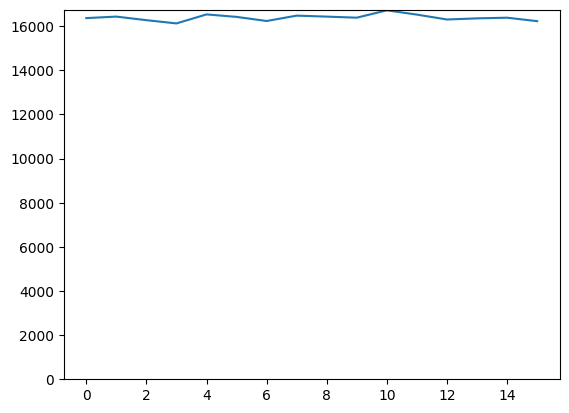

In [13]:
x = torch.randn((2**18,), device="cuda")

ids = torch.argmax(2 * x[..., None] @ NF4_GRID.T - torch.linalg.norm(NF4_GRID, dim=1) ** 2, -1)

_, counts = torch.unique(ids, return_counts=True)

plt.plot(np.arange(16), counts.cpu().numpy())
plt.ylim(0, None)